# ** Demand Forecasting  **

Demand forecasting enables companies to make significant changes to how they market, price, and plan the sale of their products. Imagine if a consumer products company - selling edible products through grocery stores - chronically put 10% more on the shelves than it sold, a buffer that ocercompensated for the risk of running out of stock. Over time, this would add up to an expensive miscalculation.

Such a forecast, when combined with an analysis of consumer, cost, and competition, would enable the company to make accurate pricing decisions. Add-in logistical and storage data, and they could assess future capacity requirements, ensure availability, and adapt vendor/distribution logistics to realize customer satisfaction.

Common solutions for demand forcasting:


1.   Traditional commercial software/platform: SPSS,SAS,JMP
2.   Commercial machine learning platform: accelerating data analysis with high level of automated machine learning, Google Cloud AutoML, Amazon SageMaker, Azure Machine Learning Studio, etc.
3.   Build in-house solution from scratch

**Project Introduction:**

In this project, we need to use historical data and external signals to develop a model to help a pharmacy store chain with the future demand on different nutrition related products. The model should provide a forecast for Summer 2016 at the SKU-quarter-Global level.

**Datasets:**

1.   **Historical_sales2.csv:** is the weekly historicak sales data for each product. The file contains the historical sales data of products at a weekly level form Spring 2014 to Spring 2016.
2.   **Products2.csv:** contains the product information, sku is the unique ID.
3.   **Predicted_list2.csv:** has the products that need demand forecasting at quarterly level. This list contains the 407 distinck products (unique ID is SKU) that need demand forcasting for quarter SU2016 (Summer 2016). It's a mix of carry-over product from previous years and newly launched products.

**Recommendation:**


1.   Fill up the last section 'prediction'.
2.   Think of any alternative approaches.
3.   If you are the data scientist/analyst in this team, how would you present your result to the business person? Any recommendations? Any further actions?






## **STEP 1: Load Packages and Input Data**

In [0]:
import pandas as pd
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import lightgbm as lgbm

In [56]:
from google.colab import files
uploaded = files.upload()
# 1. Load data as dataframe
sales_df = pd.read_csv('Historical_sales2.csv')

Saving Historical_sales2.csv to Historical_sales2 (1).csv


In [58]:
uploaded = files.upload()
product_df = pd.read_csv('Product2.csv')

Saving Product2.csv to Product2 (1).csv


In [59]:
uploaded = files.upload()
predict_df = pd.read_csv('Predicted_list2.csv')

Saving Predicted_list2.csv to Predicted_list2 (2).csv


## **STEP 2: Data Exploration**
Perform Exploratory data analyses (EDA):
1. sales_df is the weekly historical sales data for each product
2. product_df contains the product information
3. predict_df has the products that need demand forecasting at quarterly level

### 2.1 Overview of data

In [61]:
# the shapes of dataframe: (# rows, # columns)
print(sales_df.shape, product_df.shape, predict_df.shape)

(186836, 6) (407, 7) (407, 2)


In [62]:
# Preview
sales_df.head(5)

,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89
2,12/26/15,8391,GERMANY,WI2015,872,11137
3,2/6/16,8544,GERMANY,SP2016,35,121
4,7/11/15,8544,GERMANY,FA2015,0,10


In [63]:
product_df.head()

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726
2,12,G906,ADULT,powder,Echinacea,204,PATENT 1030
3,8658,C549,TODDLER,capsule,Calcium,26,PATENT 4533
4,1860,T484,ADULT,capsule,Cranberry,47,PATENT 4533|PATENT 6776


In [64]:
predict_df.head()

,sku,quarter
0,8852,SU2016
1,3403,SU2016
2,7584,SU2016
3,2057,SU2016
4,3686,SU2016


### 2.2 Check Null Value and Duplication

In [65]:
for i in [sales_df,product_df,predict_df]:
    print('Null: %s' % i.isnull().sum())
    print('Duplication: %s' % i.duplicated().sum())

Null: transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
Duplication: 1808
Null: sku            0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64
Duplication: 0
Null: sku        0
quarter    0
dtype: int64
Duplication: 0


There are 1808 duplication in sales_df. 

### 2.3 Carry_over product vs. New product

Note: product is defined by sku as instructed.


In [66]:
# mask carry-over and new products in predict_df
mask_co = predict_df['sku'].isin(sales_df['sku'])
mask_new = ~mask_co # "~" is a NOT operator

# predict_df and product_df have the same group of sku in this project

# get the new products and previous carry-over products
print ('# carry-over products:', mask_co.sum())
print ('# new productds:', mask_new.sum())

# carry-over products: 320
# new productds: 87


*   carry_over product: products having a historical data (320)
*   new product: products not having historical data (87)





### 2.4 Join tables
* Join sales_df with product_df. (left join: only carry-over products)
* new_product contains the product information of only new products

In [0]:
# aggregate Point of Sales data (sales_df) from weekly to quarterly
function1 = {'sales_amt':'sum', 'shelf_amt':'sum'}
sales_quarterly = sales_df.groupby(['sku','location','quarter'], as_index = False).agg(function1)

In [68]:
# merge pos, booking, and style into one table for carry-over
co_combine = sales_quarterly.merge(product_df,on=['sku'],how='left')
print('# of sales that missing product info:',co_combine.isnull().sum())

# of sales that missing product info: sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


In [69]:
# get product info of new product (sales data not available)
new_product = product_df[~predict_df['sku'].isin(sales_df['sku'])]
new_product.shape

(87, 7)

### 2.5 Missing Value

In this case, there is no missing value.However, in most of cases, there are some level of missing data and there are some common approaches.

Based on the % of data that is missing: 2% missing, 10% missing, 50% missing, we can use:
* Simple approach: using average value, but this lacks the insights of distribution of missing values
* Alternative approach: using a regression/classification model to predict and fill the missing values

### 2.6 Check Correlation
* plot linear correlation among the features
* sales_amt is the target metric and not included

In [70]:
co_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942 entries, 0 to 6941
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          6942 non-null   int64 
 1   location     6942 non-null   object
 2   quarter      6942 non-null   object
 3   sales_amt    6942 non-null   int64 
 4   shelf_amt    6942 non-null   int64 
 5   brand        6942 non-null   object
 6   age          6942 non-null   object
 7   formation    6942 non-null   object
 8   family       6942 non-null   object
 9   sales_price  6942 non-null   int64 
 10  specs        6942 non-null   object
dtypes: int64(4), object(7)
memory usage: 650.8+ KB


#### 2.6.1 Numerical Correlation 

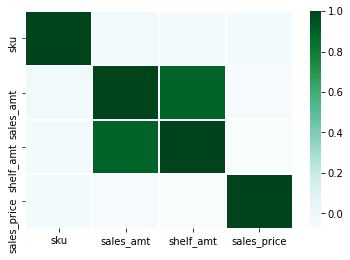

In [71]:
# Check numerical column correlation 
num_corr = co_combine.corr(method ='pearson')
sns.heatmap(num_corr, cmap="BuGn", linewidths=0.5)

'Sales_amt' and 'Shelf_amt' are highly correlated with each other, which makes sense that in order to have good sales, enough shelf quantity is necessary.

#### 2.6.2 Categorical Correlation
I will use cramer V statistics for correlation between categorical features.

In statistics, Cramér's V is a measure of association between two nominal variables, 
giving a value between 0 and +1. It is based on Pearson's chi-squared statistic。



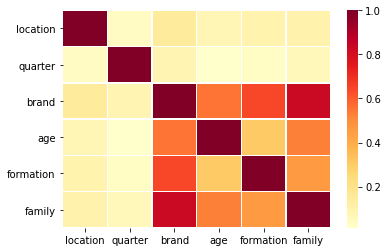

In [72]:
# categorical list without specs 
tmp_1 = ['location','quarter','brand','age','formation','family']
# correlation of the categorical features 
df_1 = co_combine[tmp_1]
chi_square = pd.DataFrame(abs(np.random.randn(len(tmp_1),len(tmp_1))), columns= tmp_1, index = tmp_1)

# cramer V statistics for correlation between categorical features

def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# chi square dataframe of categorical features
for i in tmp_1:
    temp_list = [k for k in tmp_1 if k!=i]
    for j in temp_list:
        confusion_matrix = pd.crosstab(df_1[i],df_1[j])
        val = cramers_corrected_stat(confusion_matrix)
        chi_square[i][j] = float(val) # column, row
        chi_square[i][i] = 1
        
# heatmap of categorical features (exclude the complex string)
sns.heatmap(chi_square, cmap='YlOrRd', linewidths=0.5)

There are some correlation among "brand","age","fromation", and "family" .

### 2.7 Understand Features

#### 2.7.1 Understand Numerical Features

I will use histogram to explore the numerical data because :
1. Histogram is a good visualization method
2. It is esay to find outliers
3. It is esay to find the distribution : whether the numerical data is continously ditributed or in blocks or sections(which could be define as a categorical data even if it's a float/int datatype)

In [0]:
# plot histogram with accumulative curve
def plot_hist_cum(df, column_name, title, right_range, hist_color, logscale):
    fig, ax1 = plt.subplots()
    ax1.hist(df[column_name].values, range(0,right_range), color = hist_color, 
             alpha = 0.7,density =False, log=logscale)
    ax1.tick_params(labelcolor=hist_color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.hist(df[column_name].values, range(0,right_range), histtype='step', color = 'grey', density = True, 
         cumulative = 1, lw = 2)
    ax2.tick_params(labelcolor='grey')
    plt.xlabel(column_name)
    plt.ylabel('count')
    plt.title(title)
    plt.show()

In [74]:
co_combine[['sales_amt','shelf_amt','sales_price']].describe(percentiles = [.25, .5, .75, .95])

,sales_amt,shelf_amt,sales_price
count,6942.000000,6.942000e+03,6942.000000
mean,6281.764477,1.022155e+05,88.376693
std,23467.389865,3.478001e+05,49.898150
min,0.000000,0.000000e+00,13.000000
25%,14.000000,1.705000e+02,53.000000
50%,247.000000,3.794500e+03,77.000000
75%,2714.250000,4.453200e+04,111.000000
95%,28323.800000,4.943733e+05,175.000000
max,394983.000000,5.513126e+06,306.000000


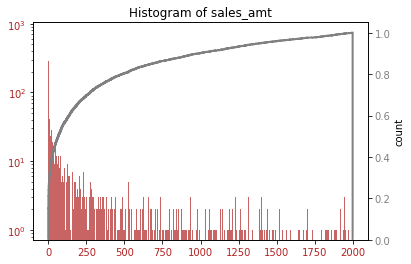

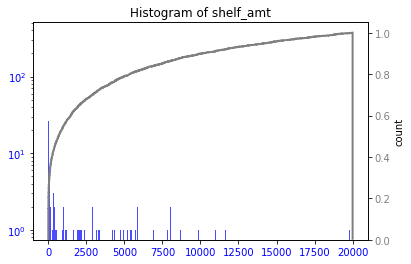

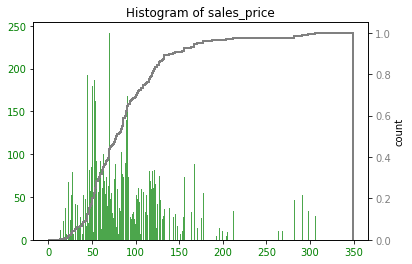

In [75]:
plot_hist_cum(co_combine, 'sales_amt', 'Histogram of sales_amt',2000,'firebrick', True)
plot_hist_cum(co_combine, 'shelf_amt', 'Histogram of shelf_amt',20000,'blue', True)
plot_hist_cum(co_combine, 'sales_price', 'Histogram of sales_price',350,'green', False)

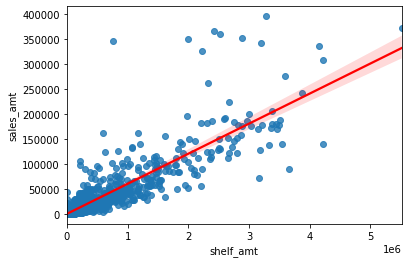

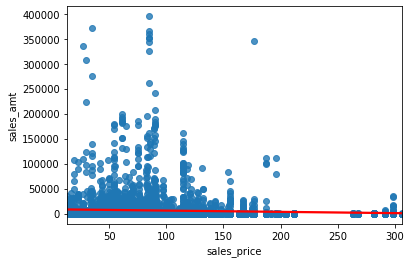

In [76]:
# plot linear dependency between the numberical (shelf_amt','sales_price') and target ('sales_amt')
for i in ['shelf_amt','sales_price']:
    sns.regplot(i,'sales_amt', data=co_combine,
               line_kws = {'color':'red'}, label = i)
    plt.show()

Similar result with the correlation heatmap, there are positive liner correlation between sales amount and shelf amount.

#### 2.7.2 Understand Categorical Features
* count of each category
* correlation between categorical feature with sales

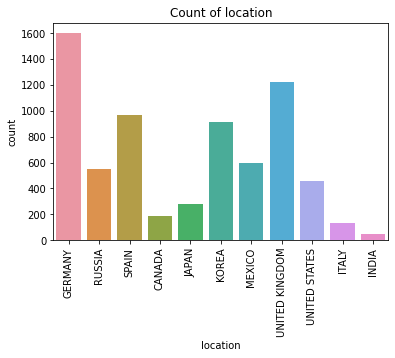

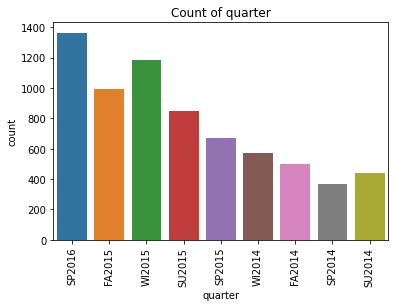

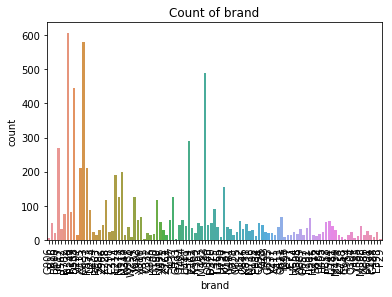

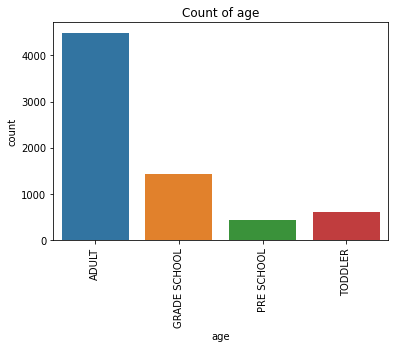

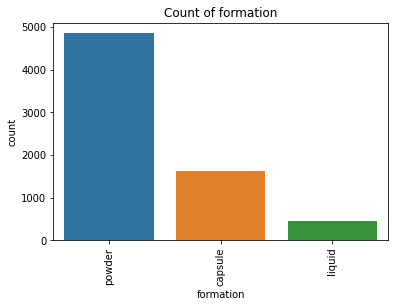

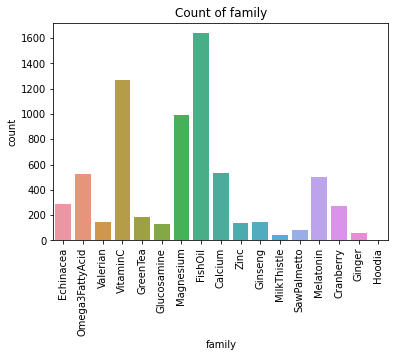

In [77]:
# check count of each category
for i in ['location','quarter','brand','age','formation','family']:
    sns.countplot(x=i, data=co_combine)
    plt.xticks(rotation=90)
    plt.title('Count of {}'.format(i))
    plt.show()

There are so many different categories in "brand", we might want to perform category merge before encoding.

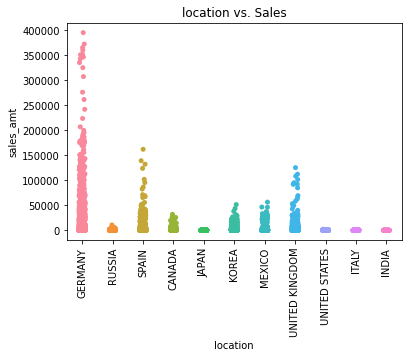

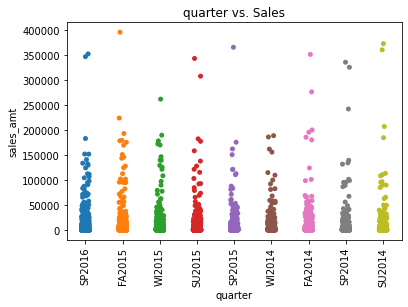

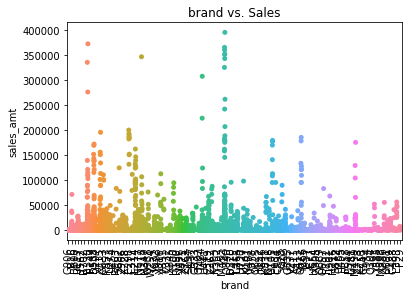

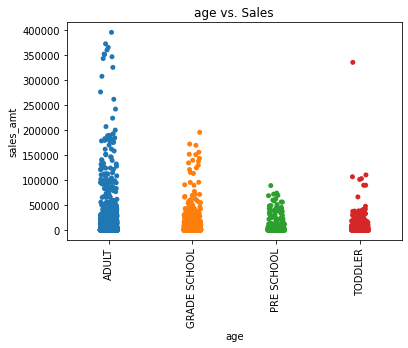

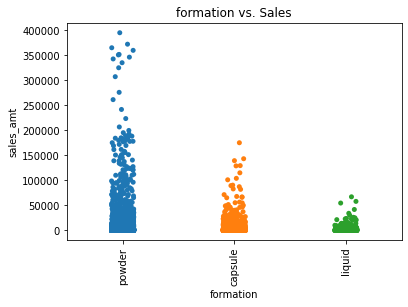

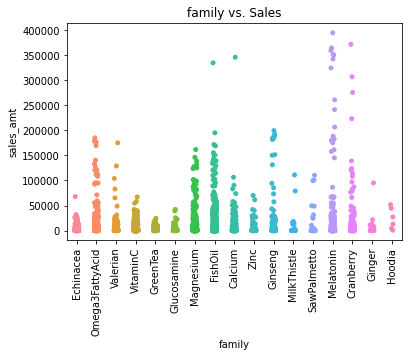

In [78]:
# correlation between categorical feature with sales
for i in ['location','quarter','brand','age','formation','family']:
    sns.stripplot(x=i, y='sales_amt', data=co_combine, jitter=True)
    plt.xticks(rotation=90)
    plt.title('{} vs. Sales'.format(i))
    plt.show()

## **STEP 3: Feature Preprocssing**

### 3.1 Extra features
* Extract "Season" and "Year" out of "quarter"
* Count # patents in a product

#### 3.1.1 Extract "Season" and "Year" out of "quarter"

In [0]:
# extract season
co_combine_1 = co_combine.copy(deep =True)
co_combine_1['season'] = co_combine_1['quarter'].astype(str).str[0:2]
# extract year
co_combine_1['year'] = co_combine_1['quarter'].astype(str).str[2:7]
#co_combine_1.drop(['quarter'], axis =1, inplace=True)

#### 3.2 Count # patents in a product (specs)

The "specs" colums contains all the technologies (patents) used in a specific product.

There are many ways to extract more features:
1.  Extract all the patent and there combination, for one-hot encoding.
2.  Count # of patents - choose
3.  etc

In [80]:
# get numnber of technology, color_family, design_code of each product
num_specs = co_combine_1['specs'].str.split('|').str.len()
co_combine_1['num_specs'] = num_specs
co_combine_1.head()

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year,num_specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030,FA,2015,1
3,12,SPAIN,SP2016,0,47,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
4,12,SPAIN,WI2015,0,32,G906,ADULT,powder,Echinacea,204,PATENT 1030,WI,2015,1


In [81]:
# treat 'specs' in new products as well
new_product_1 = new_product.copy(deep =True)
num_specs_new = new_product_1['specs'].str.split('|').str.len()
new_product_1['num_specs'] = num_specs_new
new_product_1.head()

,sku,brand,age,formation,family,sales_price,specs,num_specs
5,2778,P415,GRADE SCHOOL,powder,FishOil,77,PATENT 2876|PATENT 5726|PATENT 456,3
8,7158,C317,ADULT,powder,Zinc,229,PATENT 2876,1
11,7224,Y83,GRADE SCHOOL,powder,FishOil,84,PATENT 8830,1
23,5674,N677,ADULT,powder,Omega3FattyAcid,68,PATENT 456,1
30,13,L214,GRADE SCHOOL,capsule,FishOil,96,PATENT 8830,1


### 3.2 Bucktize and scaling
* bucktize sales_price
* scale numerical features

#### 3.2.1 Bucktize sales_price

In [0]:
# bin and convert into dummies
price = [1,30,60,80,100,180,450]
price_range = ['<=$30','$30-60','$60-80','$80-100','$100-180','>$180']
price_bin = pd.cut(co_combine_1['sales_price'], price, labels=price_range)
price_seg = pd.get_dummies(price_bin).astype(np.int64)

# carry-over
co_combine_1.drop(['sales_price'], axis =1, inplace=True)
co_combine_1 = pd.concat([co_combine_1, price_seg], axis=1)

In [0]:
# same process to new products
price_bin_new = pd.cut(new_product_1['sales_price'], price, labels=price_range)
price_seg_new = pd.get_dummies(price_bin_new).astype(np.int64)
new_product_1.drop(['sales_price'], axis =1, inplace=True)
new_product_1 = pd.concat([new_product_1, price_seg_new], axis=1)

#### 3.2.2 Scaling

In [0]:
# robust scaling
co_combine_2 = co_combine_1.copy(deep=True)
scale_lst = ['shelf_amt','num_specs']
rs_scale = preprocessing.RobustScaler().fit(co_combine_2[scale_lst])
co_combine_2[scale_lst] = rs_scale.transform(co_combine_2[scale_lst])

## **STEP 4: Modeling**

* Two models will be developed: one for carry-over products; one for new products
* The carry over model will be training on only its own historical data
* The new model will be training on the data based on similarity with the new products


### 4.1. Carry-over product model
* Use data of each product to build numerous models is not ideal, the average data point of each product/sku is 22, it is too little to build a good model
* Traditional method such as ARIMA could be used, but it lacks the 'insight' of products inner corrleation
* Build a complicated model using more products is a better option
* Target metric y = sales_amt
SP2016 data is used to evaluate the model

#### 4.1.1 Dummy features

In [0]:
cate_list = ['location','brand','age','formation','family','specs',
             'season','year']
co_combine_2 = pd.get_dummies(co_combine_2,columns=cate_list,drop_first=True) 

#### 4.1.2 Train-test Split

In [0]:
# select ~20% latest data for test purpose
co_combine_2_test = co_combine_2[co_combine_2['quarter'] =='SP2016']
co_combine_2_train = co_combine_2[co_combine_2['quarter'] !='SP2016']

In [0]:
# prepare training and test data
co_combine_2_train = shuffle(co_combine_2_train)
co_combine_2_train_X = co_combine_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_train_y = co_combine_2_train['sales_amt'] 

co_combine_2_test_X = co_combine_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_test_y = co_combine_2_test['sales_amt'] 

#### 4.1.3 Quick Baseline Model (Lasso Linear Regression)

A baseline is the result of a very basic model/solution. We generally create a baseline and then try to make more complex solutions in order to get a better result. If it achieves a better score than the baseline, it is good.

* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

##### Find hyperparameter

In [88]:
# Lasso model
#alphas = Hyperparameter in Lasso, from 10^(-0.3) to 10^(1.7) steps in 50
alphas = np.logspace (-0.3, 1.7, num=50)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(co_combine_2_train_X, co_combine_2_train_y)
    scores[i] = lasso.score(co_combine_2_test_X, co_combine_2_test_y)
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383157759.4525757, tolerance: 321756423.45932686
  positive)


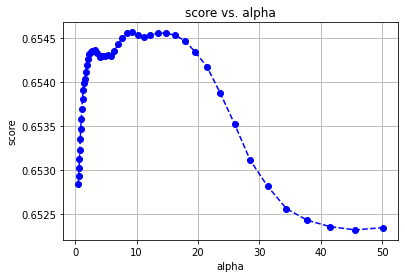

Optimal Alpha:9.232219520747307
Best Score:0.6545664092620481


In [89]:
# visualization for alphas & scores
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('Optimal Alpha:{}'.format(opt_a))
print('Best Score:{}'.format(max_score))

##### Build Model

In [0]:
# use  optimal alpha, re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(co_combine_2_train_X, co_combine_2_train_y)
lasso_pred = lasso_f.predict(co_combine_2_test_X)

##### Get Prediction

In [0]:
# compare the aggreated prediction with actual sales
co_test_lasso = co_combine_2_test.copy(deep=True)

co_test_lasso['pred'] = np.round(lasso_pred)
co_test_lasso['pred'] = co_test_lasso['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_lasso_agg = co_test_lasso.groupby(['sku','quarter'],as_index = False).agg(function_2)

##### Model Evaluation

In [0]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)

def evaluate(result_agg):
    MAPE = mean_absolute_percentage_error(result_agg['sales_amt'],result_agg['pred'])
    print('MAPE of prediction in SP2016 is {}'.format(MAPE))  #MAPE
    MAE = mean_absolute_error(result_agg['sales_amt'], result_agg['pred'])
    print('MAE of prediction in SP2016 is {}'.format(MAE))   # MAE
    MAD_ratio = mean_absolute_deviation_ratio(result_agg['sales_amt'],result_agg['pred'])
    print('MAD ratio of prediction in SP2016 is {}'.format(MAD_ratio)) # MAD ratio
    
def plot_diff(result_agg, title1, title2):    # plot the pred vs. actual
    plt.plot(result_agg['pred'],'o', color='red', alpha=0.3)
    plt.plot(result_agg['sales_amt'],'*', color='blue', alpha=0.5)
    plt.title(title1)
    plt.legend(loc= 'upper right')
    plt.show()
    plt.plot((result_agg['pred'] - result_agg['sales_amt'])
             ,'v', color='green')
    plt.title(title2)
    plt.show()

In [93]:
evaluate(co_test_lasso_agg)

MAPE of prediction in SP2016 is 1537.6025751855354
MAE of prediction in SP2016 is 10404.313479623825
MAD ratio of prediction in SP2016 is 1.0221017163270145


No handles with labels found to put in legend.


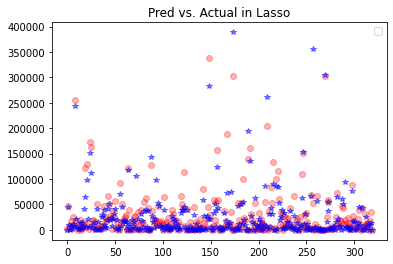

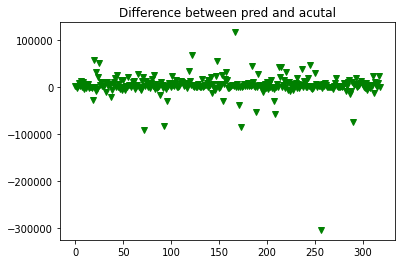

In [94]:
plot_diff(co_test_lasso_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

#### 4.1.4 Random Forest Model

##### Find hyperparameter

In [95]:
grid_1 = {'n_estimators': [5,10,15,20,30,40,50],
          'max_depth': [30,40,45,50,55,60,70]}

rf_1 = RandomForestRegressor(random_state=2019, verbose=1,n_jobs =6)
grid_rf_1 = GridSearchCV(rf_1, grid_1, cv=3)
grid_rf_1.fit(co_combine_2_train_X, co_combine_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=6,
                                             oob_score=False, random_state=2019,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_jobs=

In [0]:
# plot the hyper-parameter tuning
def class_plot(grid, grid_param, title):
    scores = [x for x in grid.cv_results_['mean_test_score']]
    m_depth = grid_param['max_depth']
    n_est = grid_param['n_estimators']
    scores = np.array(scores).reshape(len(m_depth), len(n_est))
    fig = plt.figure()
    ax = plt.subplot(111)
    for ind, i in enumerate(m_depth):
        plt.plot(n_est, scores[ind], '-o', label='Max depth' + str(i),)
    ax.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5))
    plt.xlabel('n estimator')
    plt.ylabel('Mean score')
    plt.title(title)
    plt.show()

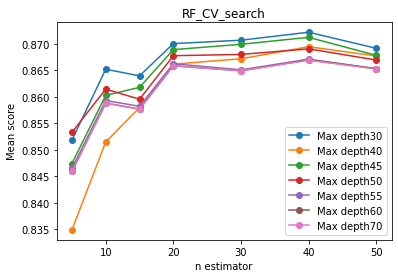

In [97]:
class_plot(grid_rf_1, grid_1, 'RF_CV_search')

In [98]:
print(grid_rf_1.best_params_)
print(grid_rf_1.best_score_)

{'max_depth': 30, 'n_estimators': 40}
0.8722328082130556


##### Build Model

In [99]:
# re-train the model with full training set
rf_best = grid_rf_1.best_estimator_
rf_best.fit(co_combine_2_train_X, co_combine_2_train_y)
pred_rf_test = rf_best.predict(co_combine_2_test_X)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


##### Find Feature Importance

In [0]:
# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

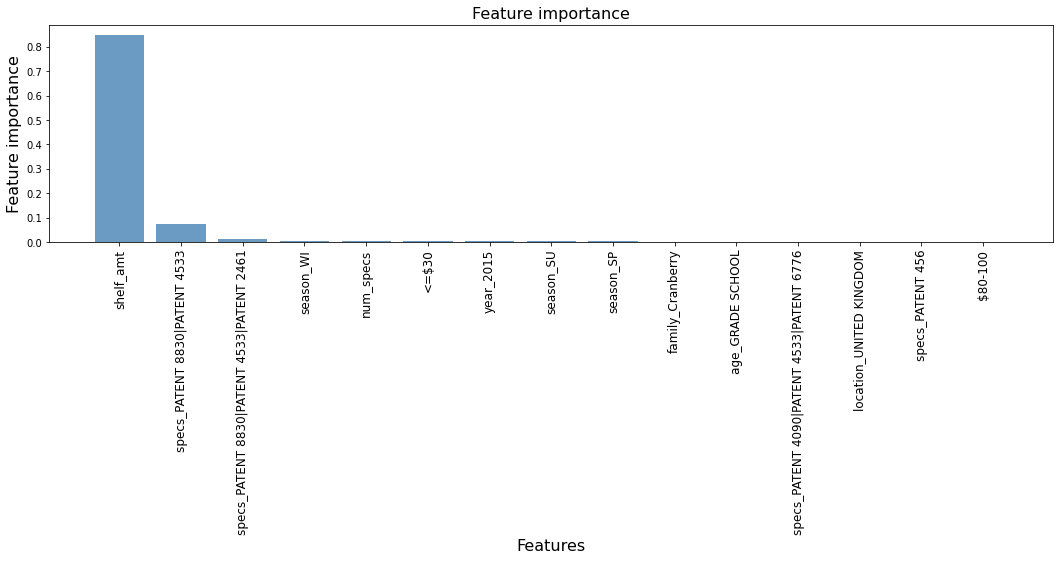

In [101]:
importance_rf_best = rf_best.feature_importances_
names_rf_best = co_combine_2_train_X.columns.tolist()
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})

# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)
plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 18, 4, 'Feature importance')

In [0]:
# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances


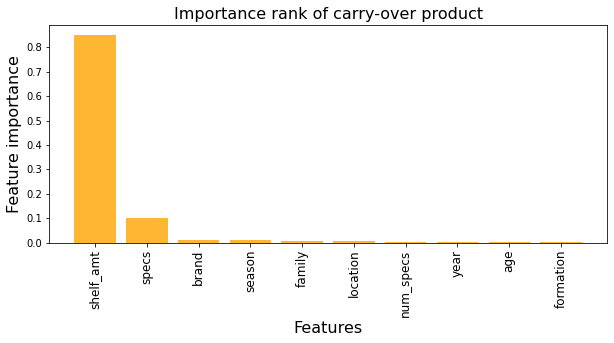

In [103]:
# plot feature importance ranking of original feature (before dummies)
raw_feature_importances_rf_best = raw_feature_importance(df_importantce_rf_best,2,cate_list)

plot_feature_importance(raw_feature_importances_rf_best, 21, 'orange', 0.8, 10, 4, 
                        'Importance rank of carry-over product')

##### Get Prediction

In [0]:
# compare the aggreated prediction with actual sales
co_test_rf = co_combine_2_test.copy(deep=True)
co_test_rf['pred'] = np.round(pred_rf_test)
co_test_rf['pred'] = co_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_rf_agg = co_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

##### Model Evaluation

In [105]:
evaluate(co_test_rf_agg)

MAPE of prediction in SP2016 is 99.5873304206424
MAE of prediction in SP2016 is 8377.0
MAD ratio of prediction in SP2016 is 0.9591056382641531


No handles with labels found to put in legend.


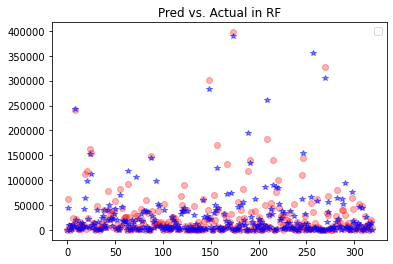

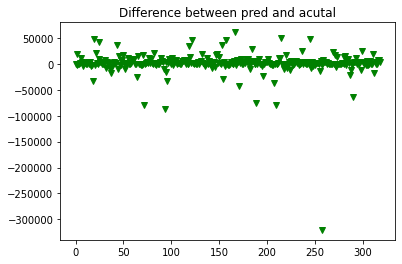

In [106]:
plot_diff(co_test_rf_agg, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

##### Retrain model with full dataset for future

In [107]:
# re-train with training+test data, save model for future prediction
co_combine_3 = co_combine_2.copy(deep =True)
co_combine_3 = shuffle(co_combine_3)
co_combine_3_X = co_combine_3.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_3_y = co_combine_3['sales_amt'] 

rf_best.fit(co_combine_3_X,co_combine_3_y)

# save model
joblib.dump(rf_best, 'rf_best_co.sav', compress=3)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.1s finished


['rf_best_co.sav']

#### 4.2 New product model

* The product is new and has not been sold before.
* Find a group of old products similiar to the new product, train a model on them, and use this model for prediction
* Clustering could be another method, number of clusters can be a hyper-parameter

##### 4.2.1 Similar product search
* Analyze the cosine similarity bewteen 87 new products in new_product_1 and 320 products in co_combine_1 with full historical data
* For each new product, the top 3 most similar old products are chosen
* Then use the data of these chosen carry-over products to train a model, which can predict demand of new products

In [0]:
similarity_prod = co_combine_1[['sku','brand','age','formation','family',
                                'specs','num_specs','<=$30','$30-60',
                                '$60-80','$80-100','$100-180','>$180']]

cate_similarity = ['brand','age','formation','family','specs']
                   
similarity_prod_dummy = pd.get_dummies(similarity_prod,columns=cate_similarity,
                                       drop_first=True) 

# get unique rows for cosine similarity compare
similarity_prod_dummy.drop_duplicates(inplace = True)

# this is later ID mapping
prod_ID = similarity_prod_dummy['sku']

# to operate cosine similarity
s_list = similarity_prod_dummy.drop(['sku'],axis=1).values.tolist()



In [0]:
new_prod_dummy = pd.get_dummies(new_product_1,columns=cate_similarity,
                                       drop_first=True) 

In [0]:
# make the same column in whole data and new product data
diff_sim = list((set(new_prod_dummy.columns) -set(similarity_prod_dummy.columns)))
if len(diff_sim)!=0:
    new_prod_dummy.drop(diff_sim, axis = 1, inplace =True)

missing_cols_sim = set(similarity_prod_dummy.columns) - set(new_prod_dummy.columns)
# Add a missing column in test set with default value equal to 0
for m in missing_cols_sim:
    new_prod_dummy[m] = 0
    
new_prod_dummy = new_prod_dummy[similarity_prod_dummy.columns]

# get unique rows for cosine similarity compare
new_prod_dummy.drop_duplicates(inplace = True)
new_prod_ID = new_prod_dummy['sku']

s_new = new_prod_dummy.drop(['sku'], axis=1)
s_new_list = s_new.values.tolist()

In [0]:
# a special dict to have list as key, to keep order
# get the similarity between 87 new products and 320 carry-over products
d_sim = defaultdict(list)

for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1,-1)
        s_list[j] = np.array(s_list[j]).reshape(1,-1)
        tmp_sim = float(cosine_similarity(s_new_list[i],s_list[j]))
        d_sim[i].append(tmp_sim)

In [0]:
# get the top 3 most similar products list with each new product
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]
# high_sim_prod_ID.tolist()

##### 4.2.2 Training/testing data for new product

In [113]:
similar_new_1 = co_combine_1[co_combine_1['sku'].isin(high_sim_prod_ID)]
print(similar_new_1.shape)
similar_new_2 = pd.get_dummies(similar_new_1,columns=cate_list,drop_first=True) 

(4141, 19)


In [0]:
# select ~20% latest data for test purpose
similar_new_2_test = similar_new_2[similar_new_2['quarter'] =='SP2016']
similar_new_2_train = similar_new_2[similar_new_2['quarter'] !='SP2016']

# prepare training and test data
similar_new_2_train = shuffle(similar_new_2_train)
similar_new_2_train_X = similar_new_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_train_y = similar_new_2_train['sales_amt'] 

similar_new_2_test_X = similar_new_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_test_y = similar_new_2_test['sales_amt'] 

##### 4.2.3 Random forest model

In [115]:
grid_2 = {'n_estimators': [15,20,30,40,50,60,70,80],
          'max_depth': [5,10,20,30,40,50]}

rf_2 = RandomForestRegressor(random_state=2019, verbose=1,n_jobs =6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv=3)
grid_rf_2.fit(similar_new_2_train_X, similar_new_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  2

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=6,
                                             oob_score=False, random_state=2019,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_jobs=

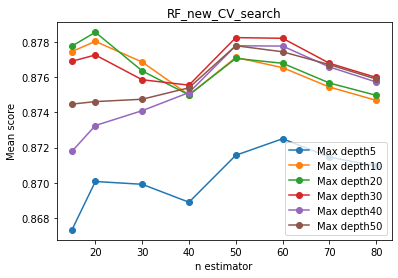

{'max_depth': 20, 'n_estimators': 20}
0.878540350816


In [116]:
class_plot(grid_rf_2, grid_2, 'RF_new_CV_search')
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

In [117]:
# re-train the model with full training set
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similar_new_2_train_X, similar_new_2_train_y)
# save model
joblib.dump(rf_best_new, 'rf_best_new.sav', compress=3)

pred_rf_test_new = rf_best_new.predict(similar_new_2_test_X)

# compare the aggreated prediction with actual sales
new_test_rf = similar_new_2_test.copy(deep=True)
new_test_rf['pred'] = np.round(pred_rf_test_new)
new_test_rf['pred'] = new_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
new_test_rf_agg = new_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


In [118]:
evaluate(new_test_rf_agg)

MAPE of prediction in SP2016 is 91.02685119102783
MAE of prediction in SP2016 is 10011.662857142857
MAD ratio of prediction in SP2016 is 0.9341627238202399


No handles with labels found to put in legend.


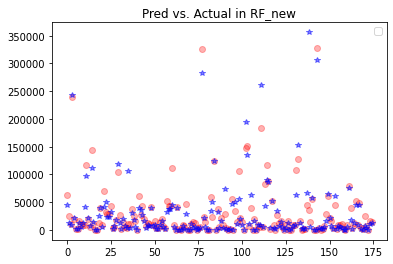

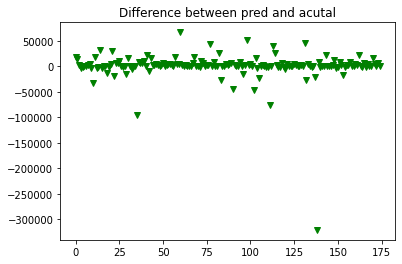

In [119]:
plot_diff(new_test_rf_agg, 'Pred vs. Actual in RF_new', 'Difference between pred and acutal')

## **STEP 5: Prediction**

* Use carry-over model and new-product model for carry-over and new products respectively
* Pre-process the input data so that they have the same columns as the data used to train the model

### 5.1 Carry-over prediction

In [0]:
# 320 carry over product prediction
co_predict_X = co_combine_2.drop(['quarter','sales_amt'], axis=1)

In [121]:
co_predict_X.head()

,sku,shelf_amt,num_specs,<=$30,$30-60,$60-80,$80-100,$100-180,>$180,location_GERMANY,location_INDIA,location_ITALY,location_JAPAN,location_KOREA,location_MEXICO,location_RUSSIA,location_SPAIN,location_UNITED KINGDOM,location_UNITED STATES,brand_B538,brand_B800,brand_C284,brand_C317,brand_C319,brand_C332,brand_C549,brand_C594,brand_C621,brand_D118,brand_D320,brand_E298,brand_E77,brand_E934,brand_F147,brand_F29,brand_F792,brand_F858,brand_G28,brand_G333,brand_G488,...,specs_PATENT 5514|PATENT 4566|PATENT 8830,specs_PATENT 5514|PATENT 5281,specs_PATENT 5514|PATENT 8830|PATENT 4090|PATENT 2876|PATENT 4533|PATENT 8924,specs_PATENT 5514|PATENT 8924,specs_PATENT 5726,specs_PATENT 5726|PATENT 4090,specs_PATENT 5726|PATENT 4533,specs_PATENT 6776,specs_PATENT 6776|PATENT 2876|PATENT 4533|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 2876|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 4090|PATENT 4533,specs_PATENT 6776|PATENT 4090|PATENT 5726,specs_PATENT 6776|PATENT 4533|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 8830|PATENT 4533|PATENT 4090,specs_PATENT 7883,specs_PATENT 8830,specs_PATENT 8830|PATENT 2876|PATENT 4533,specs_PATENT 8830|PATENT 4090,specs_PATENT 8830|PATENT 4090|PATENT 4533,specs_PATENT 8830|PATENT 4090|PATENT 456,specs_PATENT 8830|PATENT 4090|PATENT 5726,specs_PATENT 8830|PATENT 4533,specs_PATENT 8830|PATENT 4533|PATENT 2461,specs_PATENT 8830|PATENT 4533|PATENT 2876,specs_PATENT 8830|PATENT 4533|PATENT 4090,specs_PATENT 8830|PATENT 456,specs_PATENT 8830|PATENT 5281|PATENT 4533|PATENT 2876,specs_PATENT 8830|PATENT 5514,specs_PATENT 8830|PATENT 5726|PATENT 456|PATENT 4090,specs_PATENT 8895|PATENT 4533|PATENT 8998|PATENT 2461,specs_PATENT 8924|PATENT 2876,specs_PATENT 9404,specs_PATENT 9404|PATENT 4533,specs_PATENT 9545,season_SP,season_SU,season_WI,year_2015,year_2016
0,12,-0.085220,-0.5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,12,-0.084048,-0.5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,12,-0.085265,-0.5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,12,-0.084476,-0.5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,12,-0.084815,-0.5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


for the information we don't have in prediction data, fill them with 0, but always keep training and test data (i.e. prediction data) the same shape and columns.

In [0]:
for i in ['season_SP','season_WI','year_2015','shelf_amt','location_GERMANY','location_INDIA',
          'location_ITALY','location_JAPAN','location_KOREA','location_MEXICO','location_RUSSIA',
          'location_SPAIN','location_UNITED KINGDOM','location_UNITED STATES']:
    co_predict_X[i] = 0
    
co_predict_X['season_SU'] = 1
co_predict_X['year_2016'] = 1

we don't know about the detailed location information in SU2016, therefore we need to predict the sales of all 10 locations.

In [0]:
appended_data = []
for i in ['location_GERMANY','location_INDIA','location_ITALY','location_JAPAN',
          'location_KOREA','location_MEXICO','location_RUSSIA',
          'location_SPAIN','location_UNITED KINGDOM','location_UNITED STATES']:
          tmp = co_predict_X.copy(deep=True)
          tmp[i] =1
          appended_data.append(tmp)

appended_data = pd.concat(appended_data)
co_predict_X2 = appended_data.drop_duplicates()

Make prediction at sku/location level.

In [124]:
co_predict_y = rf_best.predict(co_predict_X2.drop(['sku'], axis=1))

# format the final output for carry over product
co_pred_output = pd.DataFrame()
co_pred_output['sku'] = co_predict_X2['sku']
co_pred_output['quarter'] = 'SU2016'
co_pred_output['pred_sales'] = np.around(co_predict_y, decimals=0) # round to 0 decimal


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


In [0]:
# aggregate at sku level only, i.e. sum all locations per sku
function_3 = {'pred_sales':'sum'}
co_pred_output= co_pred_output.groupby(['sku','quarter'], as_index = False).agg(function_3)


Prediction Result: co_pred_output, the final output for carry over product.

In [128]:
co_pred_output

,sku,quarter,pred_sales
0,12,SU2016,2702.0
1,37,SU2016,2923.0
2,81,SU2016,2666.0
3,147,SU2016,2778.0
4,206,SU2016,2529.0
...,...,...,...
315,9890,SU2016,2517.0
316,9908,SU2016,2393.0
317,9929,SU2016,2683.0
318,9956,SU2016,2346.0


### 5.2 New product Prediction

In [129]:
new_product_1.head()

,sku,brand,age,formation,family,specs,num_specs,<=$30,$30-60,$60-80,$80-100,$100-180,>$180
5,2778,P415,GRADE SCHOOL,powder,FishOil,PATENT 2876|PATENT 5726|PATENT 456,3,0,0,1,0,0,0
8,7158,C317,ADULT,powder,Zinc,PATENT 2876,1,0,0,0,0,0,1
11,7224,Y83,GRADE SCHOOL,powder,FishOil,PATENT 8830,1,0,0,0,1,0,0
23,5674,N677,ADULT,powder,Omega3FattyAcid,PATENT 456,1,0,0,1,0,0,0
30,13,L214,GRADE SCHOOL,capsule,FishOil,PATENT 8830,1,0,0,0,1,0,0


The new product treatment is a little different from the carry over, since the training data used to train the models are slightly different. Hence, we need to process the new product to have some features as training data.

In [0]:
new_predict_X = new_product_1.copy(deep=True)

new_predict_X['shelf_amt'] = 0
new_predict_X['season'] = 'SU'
new_predict_X['year'] = '2016'
new_predict_X['location'] = 'empty'
new_predict_X = pd.get_dummies(new_predict_X,columns=cate_list,drop_first=True) 


new_predict_X2 = new_predict_X.copy(deep=True)
for i in ['location_GERMANY','location_INDIA','location_ITALY','location_JAPAN',
          'location_KOREA','location_MEXICO','location_RUSSIA',
          'location_SPAIN','location_UNITED KINGDOM','location_UNITED STATES']:
          new_predict_X2[i] = 0

Since we don't have specific location information, here we assume the new product will be sold at all 10 locations (similiar as carry over).There are 87 new products, 10 locations, so in total we have 870 rows of data to predict.

In [0]:
appended_data2 = []

for i in ['location_GERMANY','location_INDIA','location_ITALY','location_JAPAN',
          'location_KOREA','location_MEXICO','location_RUSSIA',
          'location_SPAIN','location_UNITED KINGDOM','location_UNITED STATES']:
          tmp = new_predict_X2.copy(deep=True)
          tmp[i] =1
          appended_data2.append(tmp)

appended_data2 = pd.concat(appended_data2)
new_predict_X3 = appended_data2.drop_duplicates()

new_predict_X3_sku = new_predict_X3['sku']

Find if any new dummy columns show up, if yes, delete them, since they do not exist in training data. Simiar process with previous carry-over prediction.

In [134]:
diff_new = list((set(new_predict_X3.columns) -set(similar_new_2_train_X.columns)))
if len(diff_new) !=0:
    new_predict_X3.drop(diff_new, axis = 1, inplace =True)

# Get missing columns in the training data 'similar_new_2_train_X'
missing_cols_new = set(similar_new_2_train_X.columns) - set(new_predict_X3.columns)

# Add a missing column in test set with default value equal to 0
for s in missing_cols_new:
    new_predict_X3[s] = 0

# we know the year is 2016, and season is SU, therefore need to re-value them    
new_predict_X3['shelf_amt']=0    
new_predict_X3['year_2016'] =1
new_predict_X3['season_SU'] =1
new_predict_X3 = new_predict_X3[similar_new_2_train_X.columns.tolist()] 

# make sure the column order is same
new_predict_X3.head()

,shelf_amt,num_specs,<=$30,$30-60,$60-80,$80-100,$100-180,>$180,location_GERMANY,location_INDIA,location_ITALY,location_JAPAN,location_KOREA,location_MEXICO,location_RUSSIA,location_SPAIN,location_UNITED KINGDOM,location_UNITED STATES,brand_B538,brand_B800,brand_C284,brand_C317,brand_C319,brand_C332,brand_C594,brand_C621,brand_D118,brand_D320,brand_E77,brand_E934,brand_F147,brand_F29,brand_G28,brand_G488,brand_G633,brand_H100,brand_H216,brand_H654,brand_I632,brand_I901,...,specs_PATENT 4533|PATENT 8830|PATENT 4090,specs_PATENT 4533|PATENT 9568|PATENT 456,specs_PATENT 456,specs_PATENT 4566,specs_PATENT 4566|PATENT 4090|PATENT 9568|PATENT 4533,specs_PATENT 456|PATENT 2876,specs_PATENT 456|PATENT 2876|PATENT 4533,specs_PATENT 456|PATENT 4090,specs_PATENT 456|PATENT 4533|PATENT 2876,specs_PATENT 456|PATENT 5726|PATENT 4090,specs_PATENT 456|PATENT 8830|PATENT 2876|PATENT 4533,specs_PATENT 456|PATENT 8830|PATENT 4090,specs_PATENT 5281,specs_PATENT 5514,specs_PATENT 5514|PATENT 4533,specs_PATENT 5514|PATENT 5281,specs_PATENT 5726,specs_PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 2876|PATENT 4533|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 4090|PATENT 4533,specs_PATENT 6776|PATENT 4533|PATENT 5726|PATENT 4090,specs_PATENT 6776|PATENT 5726|PATENT 4090,specs_PATENT 8830,specs_PATENT 8830|PATENT 2876|PATENT 4533,specs_PATENT 8830|PATENT 4090,specs_PATENT 8830|PATENT 4090|PATENT 4533,specs_PATENT 8830|PATENT 4090|PATENT 5726,specs_PATENT 8830|PATENT 4533,specs_PATENT 8830|PATENT 4533|PATENT 2461,specs_PATENT 8830|PATENT 4533|PATENT 4090,specs_PATENT 8830|PATENT 456,specs_PATENT 8830|PATENT 5281|PATENT 4533|PATENT 2876,specs_PATENT 8830|PATENT 5514,specs_PATENT 8830|PATENT 5726|PATENT 456|PATENT 4090,specs_PATENT 8895|PATENT 4533|PATENT 8998|PATENT 2461,season_SP,season_SU,season_WI,year_2015,year_2016
5,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
8,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
11,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
23,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
30,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


Make prediction at sku/location level.

In [135]:
new_predict_y = rf_best_new.predict(new_predict_X3)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
# format the final output for new product
new_pred_output = pd.DataFrame()
new_pred_output['sku'] = new_predict_X3_sku
new_pred_output['quarter'] = 'SU2016'
new_pred_output['pred_sales'] = np.around(new_predict_y, decimals=0) # round to 0 decimal

# aggregate at sku level only, i.e. sum all locations per sku
# function_3 was used in carry over aggregate before
new_pred_output= new_pred_output.groupby(['sku','quarter'], as_index = False).agg(function_3) 


Prediction Result is: new_pred_output, the final output for carry over product.

In [138]:
# new_pred_output is the final output for new product
new_pred_output

,sku,quarter,pred_sales
0,13,SU2016,126.0
1,37,SU2016,896.0
2,285,SU2016,122.0
3,323,SU2016,107.0
4,525,SU2016,107.0
...,...,...,...
82,9581,SU2016,589.0
83,9615,SU2016,106.0
84,9685,SU2016,105.0
85,9693,SU2016,460.0
